<a href="https://colab.research.google.com/github/raz0208/Occlusion-Pedestrian-Detection/blob/main/DATAMININGFINALTERM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Libraries

In [76]:
import numpy as np
import pandas as pd
from google.colab import files
import random
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

%matplotlib inline

# 2-Read the data

install kaggle

In [77]:
!pip install kaggle

In [78]:
#Upload the Json file
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"rezaazariaghouieh","key":"64b7017da0efc0f9837d9dc7b0591927"}'}

In [79]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Download the data from kaggle

In [80]:
#!/bin/bash
!kaggle datasets download shuvoalok/cityscapes

Dataset URL: https://www.kaggle.com/datasets/shuvoalok/cityscapes
License(s): other
cityscapes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [81]:
# Extract the Zipfile
!unzip /content/cityscapes.zip


Archive:  /content/cityscapes.zip
replace train/img/train1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# 3 - Visualization

Showing image: train1644.png
(96, 256, 3)


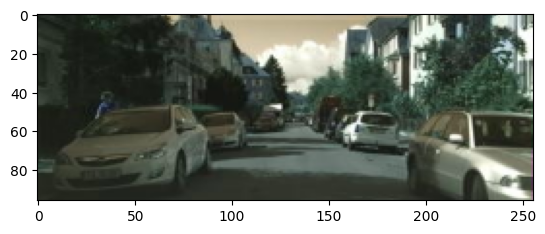

In [82]:
# Set the path to your image folder
img_folder = '/content/train/img'

# List all image files in the directory
img_files = [f for f in os.listdir(img_folder) if f.endswith('.png') or f.endswith('.jpg')]

# Check if img_files is empty
if not img_files:
    print("No image files found in the specified folder.")
else:
    # Randomly choose an image file from the list
    random_img_file = random.choice(img_files)

    # Read and display the randomly chosen image
    img_path = os.path.join(img_folder, random_img_file)
    img = cv2.imread(img_path)
    print(f"Showing image: {random_img_file}")
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Visualize the lables

Showing image: train2168.png
(96, 256, 3)


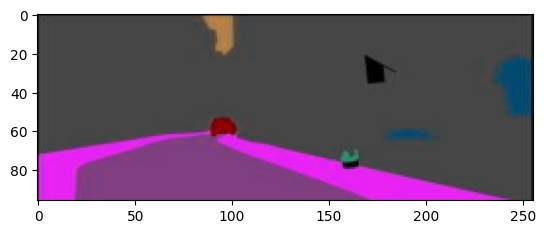

In [83]:
# Set the path to your image folder
label_folder = '/content/train/label'

# List all image files in the directory
label_files = [f for f in os.listdir(label_folder) if f.endswith('.png') or f.endswith('.jpg')]

# Check if label_files is empty
if not label_files:
    print("No image files found in the specified folder.")
else:
    # Randomly choose an image file from the list
    random_label_file = random.choice(label_files)

    # Read and display the randomly chosen image
    label_path = os.path.join(label_folder, random_label_file)
    img = cv2.imread(label_path)
    print(f"Showing image: {random_label_file}")
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Visualize both Original and lable together of Training set

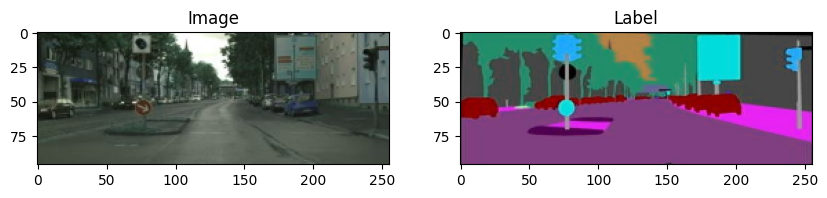

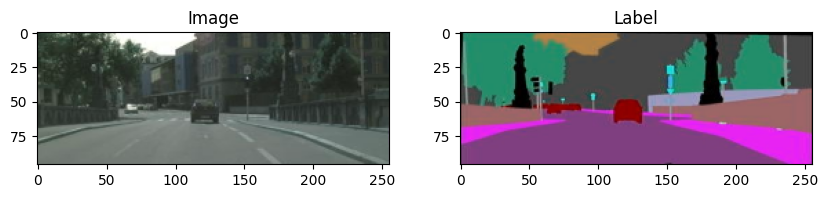

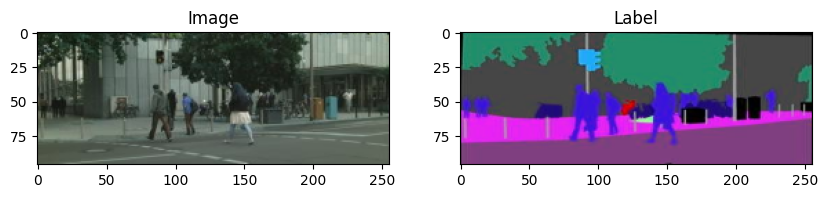

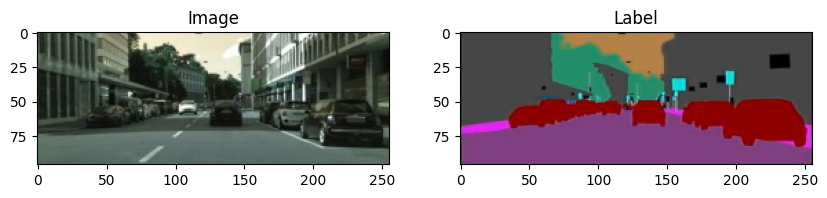

In [84]:
# Directories for images and labels
img_dir = "/content/train/img"
label_dir = "/content/train/label"

# Fetch all image paths
img_paths = [entry.path for entry in os.scandir(img_dir) if entry.is_file()]
label_paths = [entry.path for entry in os.scandir(label_dir) if entry.is_file()]

# Ensure both directories have the same number of files
num_images = min(len(img_paths), len(label_paths))

# Randomly select 4 image-label pairs
selected_indices = random.sample(range(num_images), 4)
selected_img_paths = [img_paths[i] for i in selected_indices]
selected_label_paths = [label_paths[i] for i in selected_indices]

# Display the images and labels
for img_path, label_path in zip(selected_img_paths, selected_label_paths):
    img = cv2.imread(img_path)
    label = cv2.imread(label_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
    axes[1].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image")
    axes[1].set_title("Label")
    plt.show()

Visualize both Original and lable together of Validation set



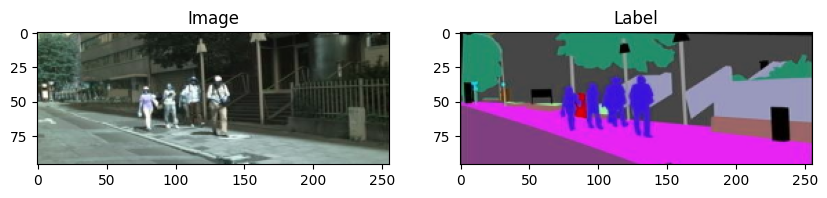

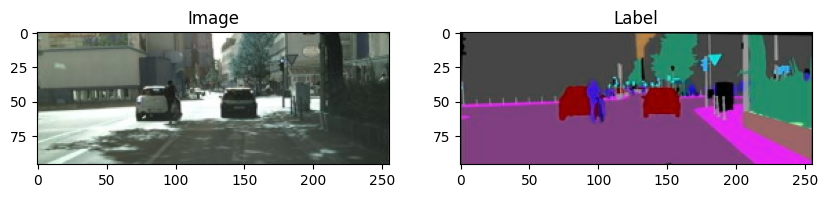

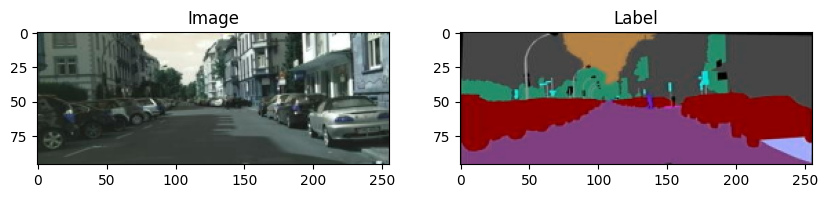

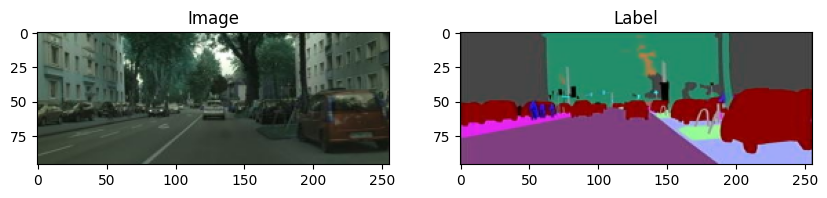

In [85]:
# Directories for images and labels
v_img_dir = "/content/val/img"
v_label_dir = "/content/val/label"

# Fetch all image paths
v_img_paths = [entry.path for entry in os.scandir(v_img_dir) if entry.is_file()]
v_label_paths = [entry.path for entry in os.scandir(v_label_dir) if entry.is_file()]

# Ensure both directories have the same number of files
num_vimages = min(len(v_img_paths), len(v_label_paths))

# Randomly select 4 image-label pairs
selected_indices = random.sample(range(num_vimages), 4)
selected_vimg_paths = [v_img_paths[i] for i in selected_indices]
selected_vlabel_paths = [v_label_paths[i] for i in selected_indices]

# Display the images and labels
for img_path, label_path in zip(selected_vimg_paths, selected_vlabel_paths):
    vimg = cv2.imread(img_path)
    vlabel = cv2.imread(label_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(vimg, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
    axes[1].imshow(cv2.cvtColor(vlabel, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image")
    axes[1].set_title("Label")
    plt.show()

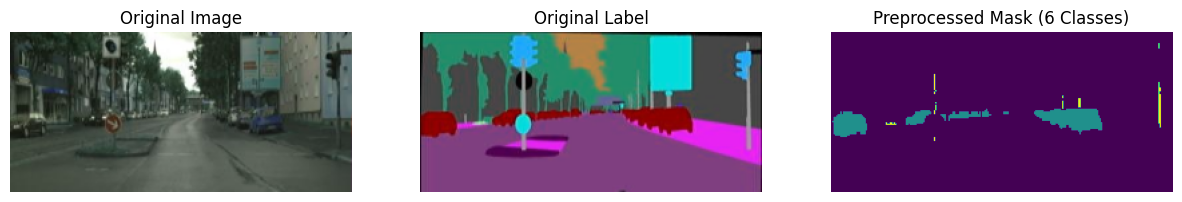

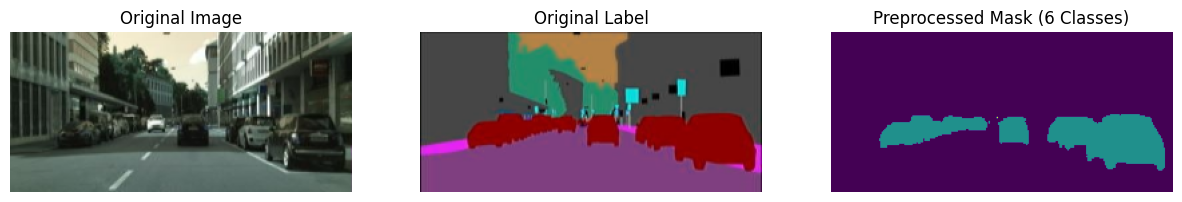

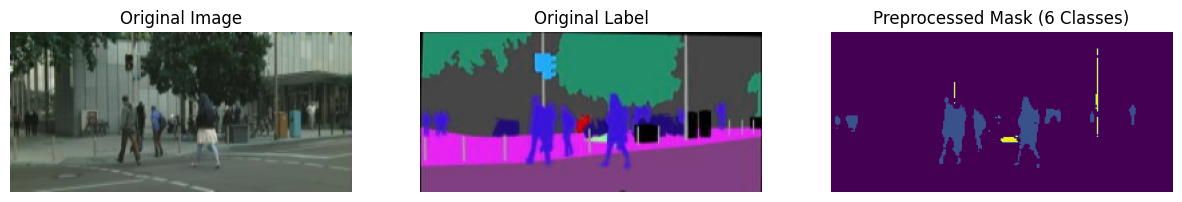

In [86]:
# Constants for image dimensions
IMG_WIDTH, IMG_HEIGHT = 256, 120  # Adjust as necessary for your dataset

# Updated target classes and tolerance
NUM_CLASSES = 6  # Roads, Pedestrians, Cars, Buildings, Sidewalks, Traffic Lights
TOLERANCE = 80   # Adjust tolerance as needed (increases color matching range)

# Define the color domains with lower and upper bounds for each color
color_ranges = {
    "roads": {
        "rgb": (127, 63, 128),       # Purple
        "class_id": 0,
        "range": [(97, 33, 98), (157, 93, 158)]  # Example tolerance range (lower bound, upper bound)
    },
    "pedestrians": {
        "rgb": (61, 19, 220),        # Blue
        "class_id": 1,
        "range": [(31, 0, 190), (91, 49, 250)]   # Adjust to match intended tolerance
    },
    "cars": {
        "rgb": (142, 0, 2),          # Red
        "class_id": 2,
        "range": [(112, 0, 0), (172, 30, 32)]    # Adjust to match intended tolerance
    },
    "buildings": {
        "rgb": (70, 70, 70),        # gray
        "class_id": 3,
        "range": [(200, 200, 0), (255, 255, 100)]  # Adjust to match intended tolerance
    },
    "sidewalks": {
        "rgb": (232, 33, 246),      # pink
        "class_id": 4,
        "range": [(150, 150, 150), (250, 250, 250)]  # Adjust to match intended tolerance
    },
    "trees": {
        "rgb": (34 , 142, 106),          # light blue
        "class_id": 5,
        "range": [(0, 200, 0), (50, 255, 50)]  # Adjust to match intended tolerance
    }
}

def preprocess_image(img_path):
    # Read and resize the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return img

def preprocess_mask(mask_path):
    # Read and convert mask to RGB
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

    # Initialize the mask with background (default: 0)
    mask_class = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.int32)

    # Apply color ranges for each class
    for color_name, color_info in color_ranges.items():
        lower_bound, upper_bound = color_info["range"]
        class_id = color_info["class_id"]

        # Create mask for pixels within the color range
        color_mask = cv2.inRange(mask, np.array(lower_bound), np.array(upper_bound))
        mask_class[color_mask > 0] = class_id

    # One-hot encode the mask
    mask_class = to_categorical(mask_class, num_classes=NUM_CLASSES)

    return mask_class

# Randomly shuffle and select 3 image-label pairs for display
def display_random_images(selected_img_paths, selected_label_paths):
    random_pairs = list(zip(selected_img_paths, selected_label_paths))
    random.shuffle(random_pairs)
    selected_pairs = random_pairs[:3]

    # Display selected image-label pairs
    for img_path, label_path in selected_pairs:
        # Process images and masks
        original_img = preprocess_image(img_path)  # Original image, resized
        original_label = preprocess_image(label_path)  # Original label, resized for consistent size
        processed_mask = preprocess_mask(label_path)  # Preprocessed mask with classes

        # Plot original image, original label, and preprocessed mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(original_img)
        axes[0].set_title("Original Image")
        axes[1].imshow(original_label)
        axes[1].set_title("Original Label")
        axes[2].imshow(np.argmax(processed_mask, axis=-1), cmap="viridis")  # Show classes in preprocessed mask
        axes[2].set_title("Preprocessed Mask (6 Classes)")

        # Hide axes for clean display
        for ax in axes:
            ax.axis("off")

        plt.show()

# Call the function to display random images
display_random_images(selected_img_paths, selected_label_paths)